In [162]:
import trsfile
import numpy as np
import matplotlib.pyplot as plt

In [24]:
with trsfile.open('/prj/side_channel/PinataTraces/CURR/CURR_TA-DL_TRAIN_10kTraces + First Round.trs', 'r') as trace_set:
    first_trace = trace_set[0]

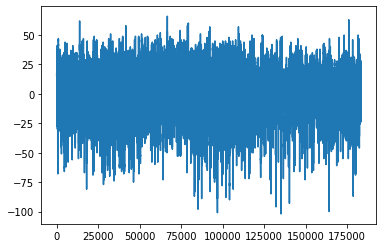

In [26]:
first_trace_samples = first_trace.samples
plt.plot(first_trace_samples)

In [27]:
with trsfile.open('/prj/side_channel/PinataTraces/CURR/CURR_TA-DL_TRAIN_10kTraces + First Round + Points of interest (CORR).trs', 'r') as first_byte_POI_trace_set:
    first_byte_POI_trace = first_byte_POI_trace_set[0]

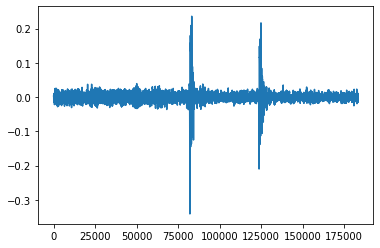

In [28]:
first_byte_POI_samples = first_byte_POI_trace.samples
plt.plot(first_byte_POI_samples)

In [37]:
# Pearson Coefficient in python: numpy.corrcoef(arr1, arr2)

## AES First-Round AddRoundKey + SubByte Implementation

Plaintext (128 bit - 16 bytes), 
(Known) Key (128 bit - 16 bytes)

sbox_in = Plaintext XOR Key -----> 
sbox_out = sbox[first_4_bits_sbox_in][last_4_bits_sbox_in] -----> Desired target

In [159]:
class LeakageModel:
    
    def __init__(self):
        # Constants
        self._supported_targets = ['SBO', 'HW'] # SBox Output, Hamming Weight
        self._sbox_dec = np.array([
            [ 99, 124, 119, 123, 242, 107, 111, 197,  48,   1, 103,  43, 254, 215, 171, 118],
            [202, 130, 201, 125, 250,  89,  71, 240, 173, 212, 162, 175, 156, 164, 114, 192],
            [183, 253, 147,  38,  54,  63, 247, 204,  52, 165, 229, 241, 113, 216,  49,  21],
            [  4, 199,  35, 195,  24, 150,   5, 154,   7,  18, 128, 226, 235,  39, 178, 117],
            [  9, 131,  44,  26,  27, 110,  90, 160,  82,  59, 214, 179,  41, 227,  47, 132],
            [ 83, 209,   0, 237,  32, 252, 177,  91, 106, 203, 190,  57,  74,  76,  88, 207],
            [208, 239, 170, 251,  67,  77,  51, 133,  69, 249,   2, 127,  80,  60, 159, 168],
            [ 81, 163,  64, 143, 146, 157,  56, 245, 188, 182, 218,  33,  16, 255, 243, 210],
            [205,  12,  19, 236,  95, 151,  68,  23, 196, 167, 126,  61, 100,  93,  25, 115],
            [ 96, 129,  79, 220,  34,  42, 144, 136,  70, 238, 184,  20, 222,  94,  11, 219],
            [224,  50,  58,  10,  73,   6,  36,  92, 194, 211, 172,  98, 145, 149, 228, 121],
            [231, 200,  55, 109, 141, 213,  78, 169, 108,  86, 244, 234, 101, 122, 174,   8],
            [186, 120,  37,  46,  28, 166, 180, 198, 232, 221, 116,  31,  75, 189, 139, 138],
            [112,  62, 181, 102,  72,   3, 246,  14,  97,  53,  87, 185, 134, 193,  29, 158],
            [225, 248, 152,  17, 105, 217, 142, 148, 155,  30, 135, 233, 206,  85,  40, 223],
            [140, 161, 137,  13, 191, 230,  66, 104,  65, 153,  45,  15, 176,  84, 187,  22]
        ]) 
        # sbox_dec = np.array([(int(x, 16) for x in sbox_hex_string.split(' '))]) to get the sbox in dec format
        # sbox_hex_string is a space-separated string of hex values of the AES SBox (in order)
        
        
    def get_labels(self, plaintext, key, target='SBO'):
        
        """ Computation of the targets for each byte of the key
        Input: 
            - plaintext: 128 bit (16 bytes) in hex format (single string without separators)
            - key: 128 bit (16 bytes) in hex format (single string without separators)
            - target: string relative to a specific target
        
        Output: Array of 16 labels (numbers) relative to the specified target
            - 'SOB': numpy array containing the SBox-lookup outputs relative to the given plaintext and key 
            - 'HW': numpy array containing the Hamming Weights of the SBox-lookup outputs relative to the given plaintext and key 
        """
        
        assert target in self._supported_targets, 'Given target is not supported!'
        
        sbox_out = self._compute_sbox_out(plaintext, key)
        
        if target == 'SBO':
            return sbox_out
        elif target == 'HW':
            return self._compute_hamming_weights(sbox_out)
        
        
    def _compute_sbox_out(self, plaintext, key):
        
        """ SBox-lookup outputs computation given plaintext and key
        Input:
            - plaintext: 128 bit (16 bytes) in hex format (single string without separators)
            - key: 128 bit (16 bytes) in hex format (single string without separators)
        
        Output: numpy array containing the SBox-lookup outputs relative to the given plaintext and key
        """
        
        assert len(plaintext) == 32, 'Wrong plaintext len!'
        assert len(key) == 32, 'Wrong key len!'
        
        int_plaintext_bytes = self._hex_to_int_bytes(plaintext) # Convert the plaintext from hex to array of int (one int for each byte)
        int_key_bytes = self._hex_to_int_bytes(key) # Convert the key from hex to array of int (one int for each byte)
        
        sbox_in = self._add_round_key(int_plaintext_bytes, int_key_bytes) # AES AddRoundKey
        
        sbox_out = self._sub_bytes(sbox_in) # AES SubBytes

        return sbox_out
        
        
    
    def _hex_to_int_bytes(self, hex_string):
        
        """ Conversion of long (128-bit) hex string to array of int, whose elements are the bytes of the input hex string
        Input: 
            - hex_string: string of hex bytes (no separators)
        
        Output: numpy array containing the int-conversion of each byte of the input 
        """
        
        assert len(hex_string)%2 == 0, 'Input len is not multiple of 2!'
        
        return np.array([int(hex_string[i:i+2], 16) for i in range(0, len(hex_string), 2)])
        
        
        
    def _add_round_key(self, plaintext, key):
        
        """ Implementation of AES AddRoundKey XORing the plaintext and the key
        Input:
            - plaintext: numpy array of int (one int per byte)
            - key: numpy array of int (one int per byte)
            
        Output: numpy array of the XOR between plaintext and key (int values) 
        """
        
        return plaintext ^ key
    
    
    def _sub_bytes(self, sbox_in):
        
        """ Implementation of AES SubBytes performing SBox-lookup
        Input:
            - sbox_in: numpy array of int relative to the input of AES SBox (one int per byte) 
        
        Output: Result of the lookup to the AES SBox 
        """
        
        sbox_in_hex = self._format_hex(sbox_in) # Convert the SBox input to well-formatted hex (each byte independently)
        
        rows = [int(byte[0], 16) for byte in sbox_in_hex] # The first 4 bits (of each byte) are the row index 
        cols = [int(byte[1], 16) for byte in sbox_in_hex] # The remaining 4 bits (of each byte) are the col index 
        
        return self._sbox_dec[rows, cols]
        
        
    def _format_hex(self, int_bytes_array):
        
        """ Conversion of an array of int to an array of hex, where the 0 in front is explicit
        Input:
            - int_bytes_array: numpy array of int (one int refers to a single byte of a hex string)
        
        Output: list of well-formatted hex values relative to the input int (0 in front in case of len-1 hex number) 
        """
        
        hex_bytes = []
        for byte in int_bytes_array:
            tmp = hex(byte)[2:] # The cast to hex generates 0x... string, so the important data start from position 2
            if len(tmp) == 1:
                tmp = f'0{tmp}'
            hex_bytes.append(tmp)
        
        return hex_bytes
    
    
    def _compute_hamming_weights(self, sbox_out):
        
        """ Hamming Weights computation given the output of the SBox-lookup
        Input:
            - sbox_out: numpy array containing the result of a SBox-lookup
        
        Output: numpy array containing the Hamming Weights of the given SBox-lookup output  
        """
        
        bin_sbox_out = [np.binary_repr(out) for out in sbox_out] # SBox Outputs from int to bin
        
        return [bin_out.count('1') for bin_out in bin_sbox_out] # Count the numbers of 1s in bin outputs
    
    
    
    


In [160]:
c = LeakageModel()
c.get_labels(plaintext='000102030405060708090A0B0C0D0E0F', key='CAFEBABEDEADBEEF0001020304050607', target='SBO')

array([116,  22, 108, 122,  87, 194, 108, 155,  48,  48,  48,  48,  48,
        48,  48,  48])

In [161]:
c.get_labels(plaintext='000102030405060708090A0B0C0D0E0F', key='CAFEBABEDEADBEEF0001020304050607', target='HW')

[4, 3, 4, 5, 5, 3, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2]